# Detecting Tweet Sentiment & Signs of Depression
Using Naive Bayes Classifier (92.9% Accuracy)

<h2> Imports</h2>

In [208]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd

<h2> Load tweets from csv file</h2>
Total of 10314 tweets compiled from Sentiment140 dataset and twitter scraping tool Twint

In [209]:
tweets = pd.read_csv('tweets.csv')
tweets.head()

,Unnamed: 0,message,label
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [210]:
tweets.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [211]:
tweets['label'].value_counts()

0    8000
1    2314
Name: label, dtype: int64

In [212]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  10314 non-null  object
 1   label    10314 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 161.3+ KB


<h2>Splitting data into train and test sets</h2>
Split: 98% train, 2% test

In [213]:
totalTweets = 8000 + 2314
trainIndex, testIndex = list(), list()
for i in range(tweets.shape[0]):
    if np.random.uniform(0, 1) < 0.98:
        trainIndex += [i]
    else:
        testIndex += [i]
trainData = tweets.iloc[trainIndex]
testData = tweets.iloc[testIndex]

In [214]:
trainData.head()

,message,label
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [215]:
testData.head()

,message,label
58,Watching the steam trains go back and forth in...,0
61,Yaaaaay. Jac is training my sorcerer to level ...,0
73,Is in Athens,0
153,pipe down. calling @Bigthangs,0
163,Watching the brady bunch,0


<h2>Wordclouds</h2>

In [216]:
from wordcloud import WordCloud

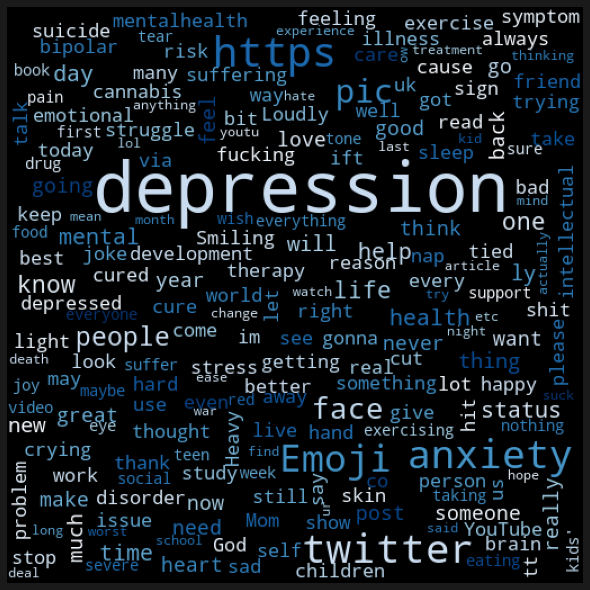

In [217]:
depressive_words = ' '.join(list(tweets[tweets['label'] == 1]['message']))
depressive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(depressive_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(depressive_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

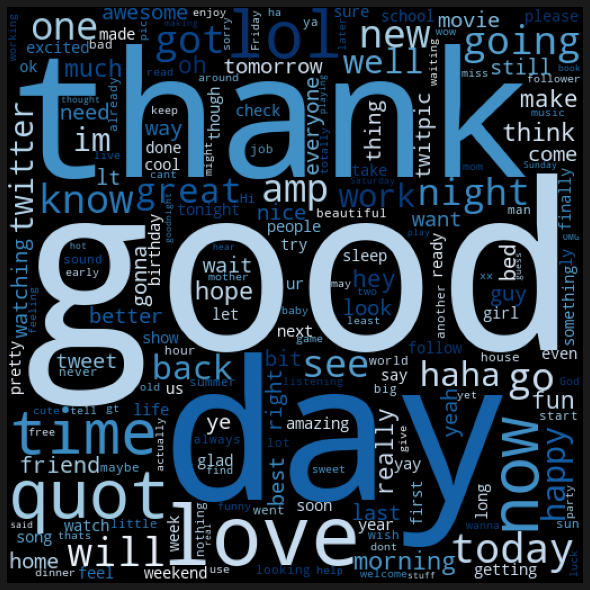

In [218]:
positive_words = ' '.join(list(tweets[tweets['label'] == 0]['message']))
positive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(positive_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(positive_wc)
plt.axis('off'), 
plt.tight_layout(pad = 0)
plt.show()

<h2>Data Pre-processing & Modelling</h2>

In [219]:
import nltk
nltk.download('punkt')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [220]:
# lower case, tokenization, stemming, and removal of stopwords
def preprocess(message, lower_case = True, stem = True, stop_words = True):
    if lower_case:
        message = message.lower()
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]   
    
    message = ' '.join(words)
    return message


In [239]:
# preprocess each message in train data
for i in range(len(trainData)):
    original = trainData.message.iloc[i]
    trainData.message.iloc[i] = preprocess(original)
    

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-239-c8cb25550f41>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainData.message.iloc[i] = preprocess(original)


In [240]:
# import packages
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [241]:
# Create a model based on Multinomial Naive Bayes
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

# Train data
model.fit(trainData.message, trainData.label)

# Create labels for test data
labels = model.predict(testData)

In [242]:
# function that returns 0 for non-depressive message and 1 for depressive
def predict_sentiment(s, trainData=trainData, model=model):
    pred = model.predict([s])
    return pred[0]

<h2>Metrics for Model</h2>

In [243]:
def metrics(testData, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(testData)):
        true_pos += int(testData.label.iloc[i] == 1 and predictions[i] == 1)
        true_neg += int(testData.label.iloc[i] == 0 and predictions[i] == 0)
        false_pos += int(testData.label.iloc[i] == 0 and predictions[i] == 1)
        false_neg += int(testData.label.iloc[i] == 1 and predictions[i] == 0)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

In [244]:
def predictions(testData):
    predictions = []
    for i in range(len(testData)):
        predictions.append(predict_sentiment(testData.message.iloc[i]))
    return predictions
        

In [245]:
metrics(testData, predictions(testData))

Precision:  0.8222222222222222
Recall:  0.8604651162790697
F-score:  0.8409090909090908
Accuracy:  0.9296482412060302


<h2>Test Predictions</h2>

In [246]:
predict_sentiment('im happy!')

0

In [255]:
predict_sentiment('Extreme sadness, lack of energy, hopelessness')

1